In [26]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [14]:
# lets load in all our data

#uc admissions data by ethnicity
ethn_16 = pd.read_csv('https://github.com/wanning-lu/MATH-189-Final-Project/raw/master/ethnicity/FR%20ENR%202016.csv', encoding='utf-16', delimiter='\t', on_bad_lines='skip')
ethn_17 =pd.read_csv('https://raw.githubusercontent.com/wanning-lu/MATH-189-Final-Project/master/ethnicity/FR%20ENR%202017.csv', encoding='utf-8')
ethn_18 = pd.read_csv('https://github.com/wanning-lu/MATH-189-Final-Project/raw/master/ethnicity/FR%20ENR%202018.csv', encoding='utf-16', delimiter='\t', on_bad_lines='skip')
ethn_19= pd.read_csv('https://github.com/wanning-lu/MATH-189-Final-Project/raw/master/ethnicity/FR%20ENR%202019.csv', encoding='utf-16', delimiter='\t', on_bad_lines='skip')
ethn_20 = pd.read_csv('https://github.com/wanning-lu/MATH-189-Final-Project/raw/master/ethnicity/FR%20ENR%202020.csv', encoding='utf-16', delimiter='\t', on_bad_lines='skip')
ethn_21 = pd.read_csv('https://github.com/wanning-lu/MATH-189-Final-Project/raw/master/ethnicity/FR%20ENR%202021.csv', encoding='utf-16', delimiter='\t', on_bad_lines='skip')
ethn_22 = pd.read_csv('https://github.com/wanning-lu/MATH-189-Final-Project/raw/master/ethnicity/FR%20ENR%202022.csv', encoding='utf-16', delimiter='\t', on_bad_lines='skip')
ethn_23 = pd.read_csv('https://github.com/wanning-lu/MATH-189-Final-Project/raw/master/ethnicity/FR%20ENR%202023.csv', encoding='utf-16', delimiter='\t', on_bad_lines='skip')

#uc admissions data by gender
gen_16 = pd.read_csv('https://raw.githubusercontent.com/wanning-lu/MATH-189-Final-Project/master/gender/2016_gender.csv', encoding='utf-16', delimiter='\t', on_bad_lines='skip')
gen_17 = pd.read_csv('https://raw.githubusercontent.com/wanning-lu/MATH-189-Final-Project/master/gender/2017_gender.csv', encoding='utf-16', delimiter='\t', on_bad_lines='skip')
gen_18 = pd.read_csv('https://raw.githubusercontent.com/wanning-lu/MATH-189-Final-Project/master/gender/2018_gender.csv', encoding='utf-16', delimiter='\t', on_bad_lines='skip')
gen_19 = pd.read_csv('https://raw.githubusercontent.com/wanning-lu/MATH-189-Final-Project/master/gender/2019_gender.csv', encoding='utf-16', delimiter='\t', on_bad_lines='skip')
gen_20 = pd.read_csv('https://raw.githubusercontent.com/wanning-lu/MATH-189-Final-Project/master/gender/2020_gender.csv', encoding='utf-16', delimiter='\t', on_bad_lines='skip')
gen_21 = pd.read_csv('https://raw.githubusercontent.com/wanning-lu/MATH-189-Final-Project/master/gender/2021_gender.csv', encoding='utf-16', delimiter='\t', on_bad_lines='skip')
gen_22 = pd.read_csv('https://raw.githubusercontent.com/wanning-lu/MATH-189-Final-Project/master/gender/2022_gender.csv', encoding='utf-16', delimiter='\t', on_bad_lines='skip')
gen_23 = pd.read_csv('https://raw.githubusercontent.com/wanning-lu/MATH-189-Final-Project/master/gender/2023_gender.csv', encoding='utf-16', delimiter='\t', on_bad_lines='skip')

#uc admissions data by gpa
gpa_16 = pd.read_csv("https://raw.githubusercontent.com/wanning-lu/MATH-189-Final-Project/master/GPA/FR%20GPA%20by%20Year_data_16.csv", index_col=0)
gpa_17 = pd.read_csv('https://raw.githubusercontent.com/wanning-lu/MATH-189-Final-Project/master/GPA/FR%20GPA%20by%20Year_data_17.csv',index_col=0)
gpa_18 = pd.read_csv('https://raw.githubusercontent.com/wanning-lu/MATH-189-Final-Project/master/GPA/FR%20GPA%20by%20Year_data_18.csv', index_col=0)
gpa_19 = pd.read_csv('https://raw.githubusercontent.com/wanning-lu/MATH-189-Final-Project/master/GPA/FR%20GPA%20by%20Year_data_19.csv', index_col=0)
gpa_20 = pd.read_csv('https://raw.githubusercontent.com/wanning-lu/MATH-189-Final-Project/master/GPA/FR%20GPA%20by%20Year_data_20.csv', index_col=0)
gpa_21 = pd.read_csv('https://raw.githubusercontent.com/wanning-lu/MATH-189-Final-Project/master/GPA/FR%20GPA%20by%20Year_data_21.csv', index_col=0)
gpa_22 = pd.read_csv('https://raw.githubusercontent.com/wanning-lu/MATH-189-Final-Project/master/GPA/FR%20GPA%20by%20Year_data_22.csv', index_col=0)
gpa_23 = pd.read_csv('https://raw.githubusercontent.com/wanning-lu/MATH-189-Final-Project/master/GPA/FR%20GPA%20by%20Year_data_23.csv', index_col=0)


#median income by household at city level from census
census = pd.read_csv('https://raw.githubusercontent.com/wanning-lu/MATH-189-Final-Project/master/Census/ACSST1Y2022.S1903-2024-05-27T042652.csv', index_col = 0)



In [17]:
#lets filter our income data to only contain californian cities


# using regex
pattern = r'California'  # This pattern matches any column name containing 'Measure'
# Use filter to select columns that match the regex pattern
matching_columns = census.filter(regex=pattern).columns
# Drop columns that do not match the pattern
census_filtered = census[matching_columns]

#keep only income
estimates = r'Estimate'
# Use filter to select columns that match the regex pattern
matching_columns2 = census_filtered.filter(regex=estimates).columns
# Drop columns that do not match the pattern
census_income = census_filtered[matching_columns2]


#keep only income
Inc = r'Median income'
# Use filter to select columns that match the regex pattern
matching_columns3 = census_income.filter(regex=Inc).columns
# Drop columns that do not match the pattern
california_income = census_filtered[matching_columns3]


# clean up column names
column_mapping = {col: col.split(',')[0] for col in california_income.columns}

# rename columns
california_income = california_income.rename(columns=column_mapping)

#clean up column names some more
def remove_last_word(s):
    return ' '.join(s.split()[:-1])

column_mapping = {col: remove_last_word(col) for col in california_income.columns}

california_income = california_income.rename(columns=column_mapping)

#lets get the cities as rows so we can merge it a bit easier
california_income = california_income.T

#lets bring the cities into a col so easier to merge
california_income = california_income.reset_index(drop=False)

#rename column
california_income = california_income.rename(columns={'index': 'City', '\xa0\xa0\xa0\xa0Households': 'Household Income'})

#lets keep only city and income data
california_income = california_income[['City', 'Household Income']]
#lets make income into ints
california_income['Household Income'] = california_income['Household Income'].str.replace(',', '').astype(int)
california_income.head()


Label (Grouping),City,Household Income
0,California!!Median income,91551
1,Alameda,131116
2,Alhambra,72406
3,Anaheim,85133
4,Antioch,100178


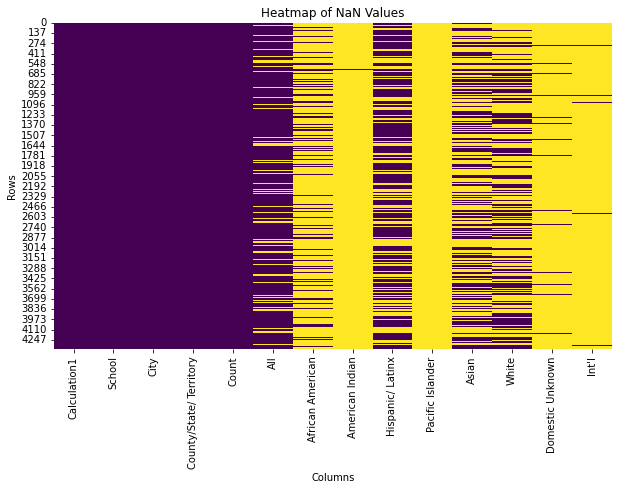

In [18]:
#lets see how many Na values we have in our ethnicity data

nan_df = ethn_16.isna()

# Set up the matplotlib figure
plt.figure(figsize=(10, 6))

# Create a heatmap
sns.heatmap(nan_df, cmap='viridis', cbar=False)

# Add labels and title
plt.xlabel('Columns')
plt.ylabel('Rows')
plt.title('Heatmap of NaN Values')

# Show the plot
plt.show()

The documentation say for any category with < 5 students, it is entered as null. We will have decidide how we will deal with this.

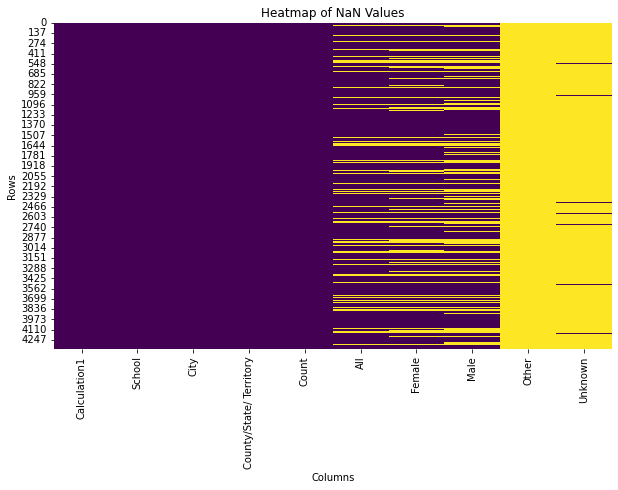

In [19]:
#lets see how many Na values we have in our gender data

nan_df = gen_16.isna()

# Set up the matplotlib figure
plt.figure(figsize=(10, 6))

# Create a heatmap
sns.heatmap(nan_df, cmap='viridis', cbar=False)

# Add labels and title
plt.xlabel('Columns')
plt.ylabel('Rows')
plt.title('Heatmap of NaN Values')

# Show the plot
plt.show()

The documentation say for any category with < 5 students, it is entered as null. We will have decidide how we will deal with this.

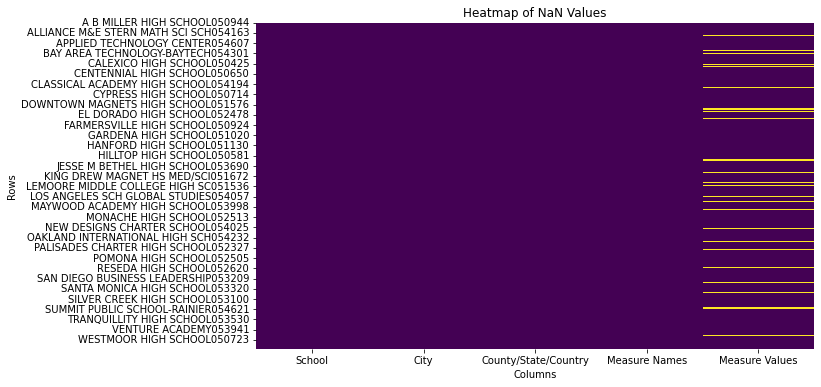

In [20]:
#lets see how many Na values we have in our gpa data

nan_df = gpa_16.isna()

# Set up the matplotlib figure
plt.figure(figsize=(10, 6))

# Create a heatmap
sns.heatmap(nan_df, cmap='viridis', cbar=False)

# Add labels and title
plt.xlabel('Columns')
plt.ylabel('Rows')
plt.title('Heatmap of NaN Values')

# Show the plot
plt.show()

The documentation say for any category with < 5 students, it is entered as null. We will have decidide how we will deal with this.

In [58]:

merged_df_16 = pd.merge(ethn_16, california_income, on='City', how='inner')

merged_df_16 = pd.merge(merged_df_16, gen_16, on=['Calculation1', 'School', 'County/State/ Territory','Count','All', 'City'], how='inner')

merged_df_16 = pd.merge(merged_df_16, gpa_16, on=['City','School'], how='inner')
merged_df_16 = merged_df_16.set_index('Count')
merged_df_16.head()

,Calculation1,School,City,County/State/ Territory,All,African American,American Indian,Hispanic/ Latinx,Pacific Islander,Asian,White,Domestic Unknown,Int'l,Household Income,Female,Male,Other,Unknown,County/State/Country,Measure Names,Measure Values
Count,,,,,,,,,,,,,,,,,,,,,
App,A B MILLER HIGH SCHOOL50944,A B MILLER HIGH SCHOOL,Fontana,San Bernardino,101.0,NaN,NaN,52.0,NaN,NaN,NaN,40.0,NaN,93581,31.0,32.0,NaN,38.0,San Bernardino,Enrl GPA,3.784390
App,A B MILLER HIGH SCHOOL50944,A B MILLER HIGH SCHOOL,Fontana,San Bernardino,101.0,NaN,NaN,52.0,NaN,NaN,NaN,40.0,NaN,93581,31.0,32.0,NaN,38.0,San Bernardino,Adm GPA,3.620526
App,A B MILLER HIGH SCHOOL50944,A B MILLER HIGH SCHOOL,Fontana,San Bernardino,101.0,NaN,NaN,52.0,NaN,NaN,NaN,40.0,NaN,93581,31.0,32.0,NaN,38.0,San Bernardino,App GPA,3.522178
Adm,A B MILLER HIGH SCHOOL50944,A B MILLER HIGH SCHOOL,Fontana,San Bernardino,76.0,NaN,NaN,32.0,NaN,NaN,NaN,36.0,NaN,93581,23.0,18.0,NaN,35.0,San Bernardino,Enrl GPA,3.784390
Adm,A B MILLER HIGH SCHOOL50944,A B MILLER HIGH SCHOOL,Fontana,San Bernardino,76.0,NaN,NaN,32.0,NaN,NaN,NaN,36.0,NaN,93581,23.0,18.0,NaN,35.0,San Bernardino,Adm GPA,3.620526
Adm,A B MILLER HIGH SCHOOL50944,A B MILLER HIGH SCHOOL,Fontana,San Bernardino,76.0,NaN,NaN,32.0,NaN,NaN,NaN,36.0,NaN,93581,23.0,18.0,NaN,35.0,San Bernardino,App GPA,3.522178
Enr,A B MILLER HIGH SCHOOL50944,A B MILLER HIGH SCHOOL,Fontana,San Bernardino,41.0,NaN,NaN,21.0,NaN,NaN,NaN,14.0,NaN,93581,17.0,11.0,NaN,13.0,San Bernardino,Enrl GPA,3.784390
Enr,A B MILLER HIGH SCHOOL50944,A B MILLER HIGH SCHOOL,Fontana,San Bernardino,41.0,NaN,NaN,21.0,NaN,NaN,NaN,14.0,NaN,93581,17.0,11.0,NaN,13.0,San Bernardino,Adm GPA,3.620526
Enr,A B MILLER HIGH SCHOOL50944,A B MILLER HIGH SCHOOL,Fontana,San Bernardino,41.0,NaN,NaN,21.0,NaN,NaN,NaN,14.0,NaN,93581,17.0,11.0,NaN,13.0,San Bernardino,App GPA,3.522178


In [11]:

merged_df_17 = pd.merge(ethn_17, california_income, on='City', how='inner')

merged_df_17 = pd.merge(merged_df_17, gen_17, on=['Calculation1', 'School', 'County/State/ Territory','Count','All', 'City'], how='inner')

merged_df_17 = pd.merge(merged_df_17, gpa_17, on=['City','School'], how='inner')

merged_df_17.head()

In [12]:

merged_df_18 = pd.merge(ethn_18, california_income, on='City', how='inner')

merged_df_18 = pd.merge(merged_df_18, gen_18, on=['Calculation1', 'School', 'County/State/ Territory','Count','All', 'City'], how='inner')

merged_df_18 = pd.merge(merged_df_18, gpa_18, on=['City','School'], how='inner')

merged_df_18.head()

In [ ]:

merged_df_19 = pd.merge(ethn_19, california_income, on='City', how='inner')

merged_df_19 = pd.merge(merged_df_19, gen_19, on=['Calculation1', 'School', 'County/State/ Territory','Count','All', 'City'], how='inner')

merged_df_19 = pd.merge(merged_df_19, gpa_19, on=['City','School'], how='inner')

merged_df_19.head()

In [ ]:

merged_df_20 = pd.merge(ethn_20, california_income, on='City', how='inner')

merged_df_20 = pd.merge(merged_df_20, gen_20, on=['Calculation1', 'School', 'County/State/ Territory','Count','All', 'City'], how='inner')

merged_df_20 = pd.merge(merged_df_20, gpa_20, on=['City','School'], how='inner')

merged_df_20.head()

In [ ]:

merged_df_21 = pd.merge(ethn_21, california_income, on='City', how='inner')

merged_df_21 = pd.merge(merged_df_21, gen_21, on=['Calculation1', 'School', 'County/State/ Territory','Count','All', 'City'], how='inner')

merged_df_21 = pd.merge(merged_df_21, gpa_21, on=['City','School'], how='inner')

merged_df_21.head()

In [ ]:

merged_df_22 = pd.merge(ethn_22, california_income, on='City', how='inner')

merged_df_22 = pd.merge(merged_df_22, gen_22, on=['Calculation1', 'School', 'County/State/ Territory','Count','All', 'City'], how='inner')

merged_df_22 = pd.merge(merged_df_22, gpa_22, on=['City','School'], how='inner')

merged_df_22.head()

In [ ]:

merged_df_23 = pd.merge(ethn_23, california_income, on='City', how='inner')

merged_df_23 = pd.merge(merged_df_23, gen_23, on=['Calculation1', 'School', 'County/State/ Territory','Count','All', 'City'], how='inner')

merged_df_23 = pd.merge(merged_df_23, gpa_23, on=['City','School'], how='inner')

merged_df_23.head()